In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
from nebula.util.common import read_pickle, write_pickle
import pandas as pd
import numpy as np

In [10]:
data = pd.read_pickle('wv_sep_clustered.pkl')

In [11]:
data.head()

,ticker,wv,cluster
date,,,
2018-07-03 18:16:26,CNC,"[-0.17302, 0.075893, -0.024329, 0.15359, -0.06...",8
2014-01-30 13:09:06,NFLX,"[0.13868, -0.089551, 0.1198, -0.04696, 0.44213...",6
2019-06-18 13:10:14,ABT,"[0.28608, -0.26698, -0.12005, 0.12283, 0.34215...",0
2019-06-18 13:10:14,AFL,"[0.28608, -0.26698, -0.12005, 0.12283, 0.34215...",0
2019-06-18 13:10:14,ALK,"[0.28608, -0.26698, -0.12005, 0.12283, 0.34215...",0


In [5]:
returns = pd.read_pickle('sp500_daily_returns.pkl')

In [6]:
returns.head()

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1962-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
sp500_gics = pd.read_pickle('sp500_gics.pkl')

In [9]:
sp500_gics.head()

,GICS Sector
Symbol,
MMM,Industrials
ABT,Health Care
ABBV,Health Care
ABMD,Health Care
ACN,Information Technology


In [12]:
data.index = pd.to_datetime(data.index.map(lambda x: x.date()))

In [13]:
data.head()

,ticker,wv,cluster
date,,,
2018-07-03,CNC,"[-0.17302, 0.075893, -0.024329, 0.15359, -0.06...",8
2014-01-30,NFLX,"[0.13868, -0.089551, 0.1198, -0.04696, 0.44213...",6
2019-06-18,ABT,"[0.28608, -0.26698, -0.12005, 0.12283, 0.34215...",0
2019-06-18,AFL,"[0.28608, -0.26698, -0.12005, 0.12283, 0.34215...",0
2019-06-18,ALK,"[0.28608, -0.26698, -0.12005, 0.12283, 0.34215...",0


In [15]:
data = data.sort_index()

In [18]:
data.columns = ['ticker', 'wv', 'factor']

In [19]:
data = data[['ticker', 'factor']]

In [21]:
data['value'] = 1

In [22]:
data = data.set_index(['ticker', 'factor'], append=True)

In [25]:
data = data.groupby(['date', 'ticker', 'factor']).sum()

In [27]:
data = data.squeeze()

In [29]:
data = data.unstack()

In [31]:
data.to_pickle('factors_sep_res.pkl')

<AxesSubplot:xlabel='date'>

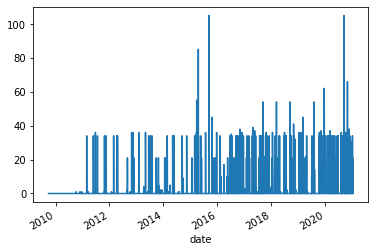

In [36]:
data[3].groupby('date').count().plot()

In [37]:
import missingno as msno

In [38]:
factor0 = data[0]

In [40]:
factor0 = factor0.unstack()

<AxesSubplot:>

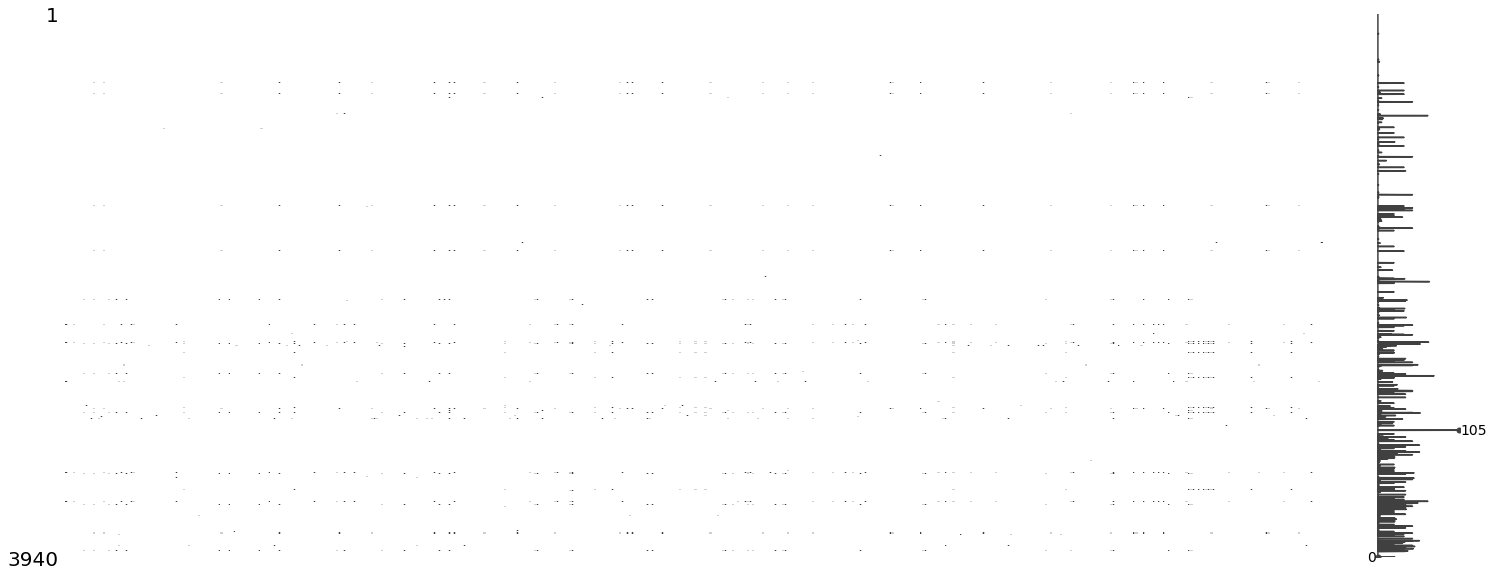

In [41]:
msno.matrix(factor0)

In [43]:
def cumulative_returns(returns):

    res = (returns + 1.0).cumprod()

    return res

def equal_weight(factor):
    eq_factor = pd.DataFrame(1, index=factor.index, columns=factor.columns)
    return eq_factor


def factor_strategy(factor, roll=None, leverage=1, groups=None, neutral=False):
    factor = factor.copy()
    if roll is not None:
        factor = factor.rolling(roll, min_periods=1).sum()
        
    group_weights = None
    if groups is not None:
        groups = groups.copy()
        grp_col = groups.columns[0]
        res = groups.reindex(factor.columns).set_index(grp_col, append=True)
        res = res.reorder_levels([grp_col, 'ticker']).index
        factor.columns = res
        if neutral:
            factor_sn = factor.div(factor.groupby(grp_col, axis='columns').sum(), axis='rows')
        else:
            factor_sn = factor
        
        group_weights = factor_sn.groupby(grp_col, axis='columns').sum()
        
        factor_sn.columns = factor_sn.columns.droplevel(0)
        factor = factor_sn
        
    factor_count = factor.sum(axis=1)
    factor_strategy = factor.div(factor_count, axis='rows')
    return factor_strategy.mul(leverage), group_weights


def calc_returns(factor_strategy, returns, trade_cost=None):
    strategy_sod = factor_strategy.copy()
    strategy_sod.index = strategy_sod.index.shift(1, 'B')
    
    returns = returns.reindex(strategy_sod.index)
    returns = returns[strategy_sod.columns]
    
    daily_returns = strategy_sod.mul(returns).sum(axis='columns')
    
    if trade_cost is not None:
        trades = strategy_sod.sub(strategy_sod.shift(1))
        daily_returns = daily_returns.sub(trades.abs().mul(trade_cost).sum(axis='columns'))
    
    cum_returns = cumulative_returns(daily_returns)
    
    return cum_returns, daily_returns


def performance_data(factor, returns, roll=None, title=None, leverage=1, groups=None, trade_cost=None, neutral=False):
    strat, gweights = factor_strategy(factor, roll, leverage, groups=groups, neutral=neutral)
    ret, daily_ret = calc_returns(strat, returns, trade_cost=trade_cost)
    
    if title is None:
        title = f'roll-{roll}'
    ret.name = title
    daily_ret.name = title
    gweights.name = title
    
    return ret, daily_ret, gweights


def performance_data_list(factor, returns, rolls=[], groups=None, trade_cost=None, neutral=False):
    rets = []
    drets = []
    gwgts = []
    
    ret, dret, gw = performance_data(equal_weight(factor), returns, title='equal weight', groups=groups, trade_cost=trade_cost, neutral=neutral)
    rets.append(ret)
    drets.append(dret)
    gwgts.append(gw)
    
    ret, dret, gw = performance_data(equal_weight(factor), returns, title='equal weight 1.5', leverage=1.5, groups=groups, trade_cost=trade_cost, neutral=neutral)
    rets.append(ret)
    drets.append(dret)
    gwgts.append(gw)

    ret, dret, gw = performance_data(factor, returns, groups=groups, trade_cost=trade_cost, neutral=neutral)
    rets.append(ret)
    drets.append(dret)
    gwgts.append(gw)

    for roll in rolls:
        ret, dret, gw = performance_data(factor, returns, roll, groups=groups, trade_cost=trade_cost, neutral=neutral)
        rets.append(ret)
        drets.append(dret)
        gwgts.append(gw)
        
    rets = pd.concat(rets, axis=1)
    drets = pd.concat(drets, axis=1)
    return rets, drets, gwgts

In [48]:
import nebula.finance.analytics.performance as nperf

roll-None          -1.573605
roll-2             -0.803418
roll-13            -0.665449
roll-10            -0.623337
roll-5             -0.611211
roll-15            -0.564520
roll-8             -0.512940
roll-100           -0.068724
equal weight        0.000000
equal weight 1.5    0.245652
dtype: float64

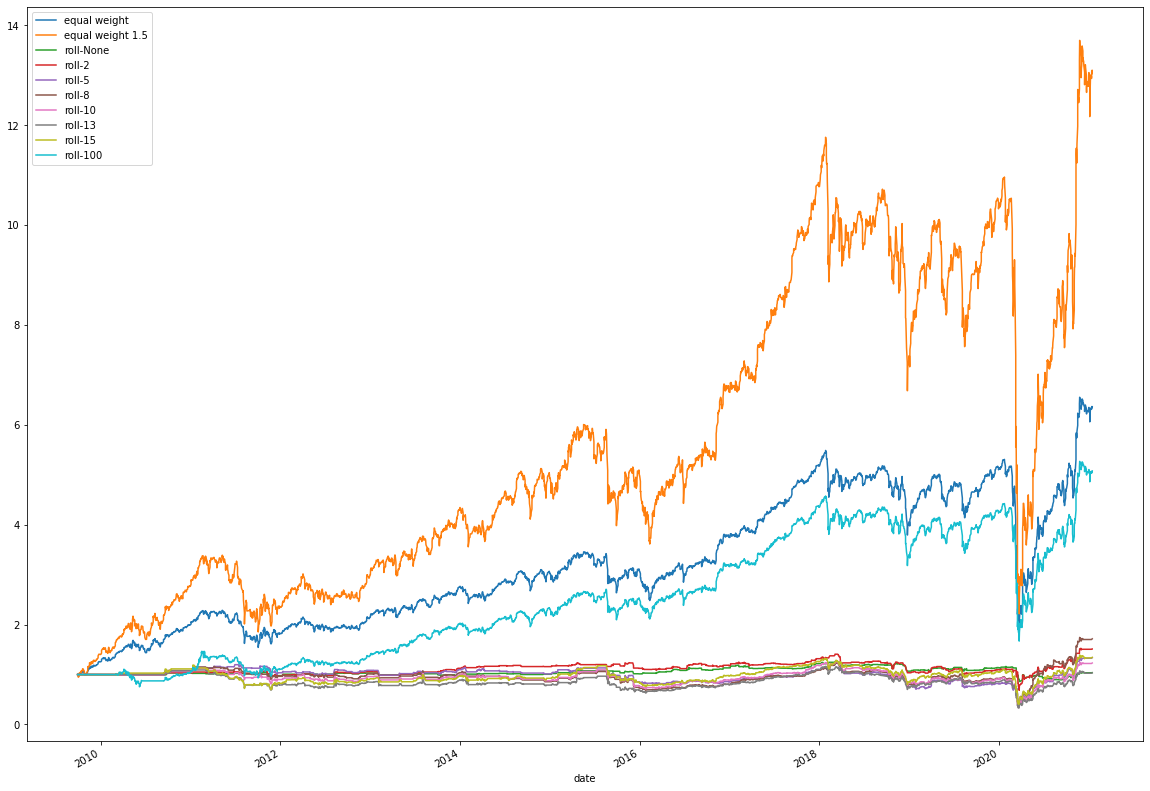

In [49]:
factor = data[0].unstack()
rets_imp, drets_imp, gwgts = performance_data_list(factor, returns, rolls=[2, 5, 8, 10, 13, 15, 100], groups=sp500_gics)
rets_imp.plot(figsize=(20, 15))
nperf.sharpe(drets_imp, returns_ref=drets_imp['equal weight']).sort_values()

roll-10            -0.471715
roll-8             -0.393584
roll-13            -0.346239
roll-None          -0.299112
roll-15            -0.278981
roll-5             -0.092369
roll-2             -0.052574
roll-100           -0.006641
equal weight        0.000000
equal weight 1.5    0.245652
dtype: float64

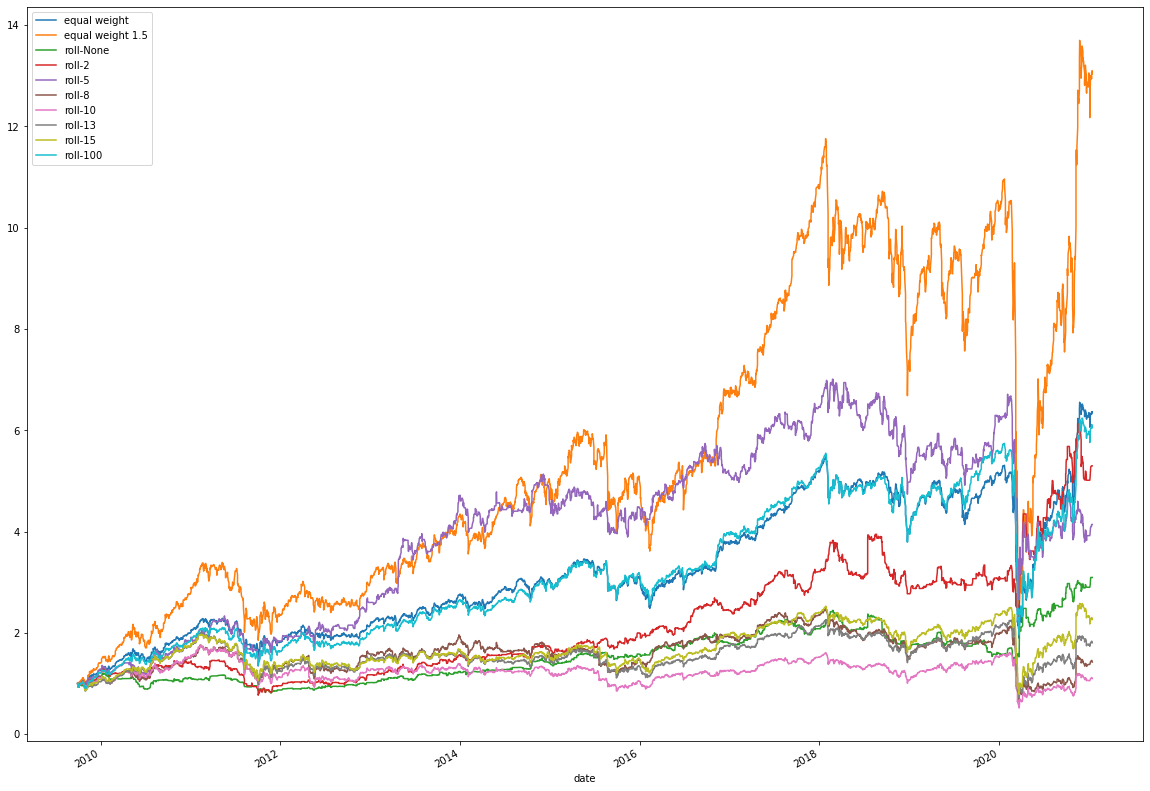

In [50]:
factor = data[1].unstack()
rets_imp, drets_imp, gwgts = performance_data_list(factor, returns, rolls=[2, 5, 8, 10, 13, 15, 100], groups=sp500_gics)
rets_imp.plot(figsize=(20, 15))
nperf.sharpe(drets_imp, returns_ref=drets_imp['equal weight']).sort_values()

roll-None          -0.108090
roll-2             -0.040743
equal weight        0.000000
roll-100            0.024529
roll-5              0.031593
roll-15             0.102138
roll-13             0.133301
roll-10             0.161121
roll-8              0.161609
equal weight 1.5    0.245652
dtype: float64

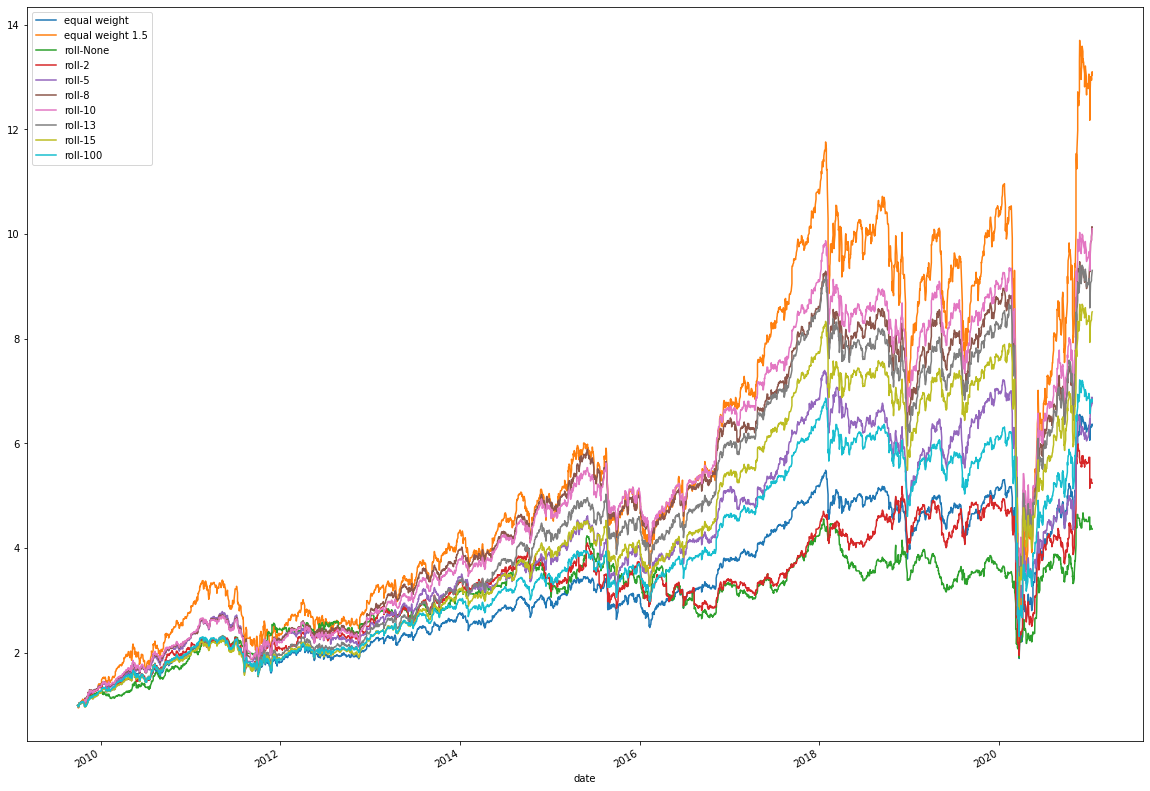

In [51]:
factor = data[2].unstack()
rets_imp, drets_imp, gwgts = performance_data_list(factor, returns, rolls=[2, 5, 8, 10, 13, 15, 100], groups=sp500_gics)
rets_imp.plot(figsize=(20, 15))
nperf.sharpe(drets_imp, returns_ref=drets_imp['equal weight']).sort_values()

roll-None          -1.842865
roll-2             -1.180158
roll-5             -1.111797
roll-8             -0.963571
roll-15            -0.874150
roll-10            -0.808262
roll-13            -0.802079
roll-100           -0.408065
equal weight        0.000000
equal weight 1.5    0.245652
dtype: float64

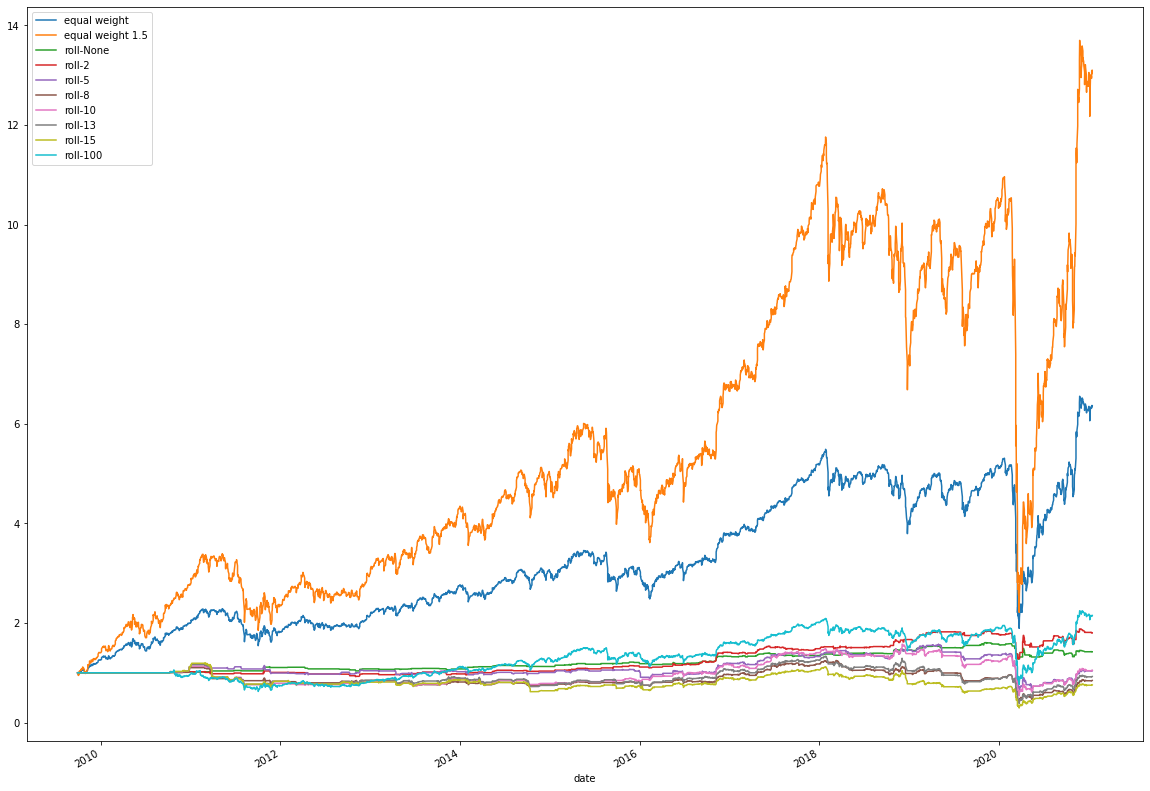

In [52]:
factor = data[3].unstack()
rets_imp, drets_imp, gwgts = performance_data_list(factor, returns, rolls=[2, 5, 8, 10, 13, 15, 100], groups=sp500_gics)
rets_imp.plot(figsize=(20, 15))
nperf.sharpe(drets_imp, returns_ref=drets_imp['equal weight']).sort_values()

roll-None          -2.289913
roll-2             -1.493246
roll-5             -1.211898
roll-10            -0.949124
roll-13            -0.942083
roll-8             -0.760618
roll-15            -0.727631
roll-100           -0.237710
equal weight        0.000000
equal weight 1.5    0.245652
dtype: float64

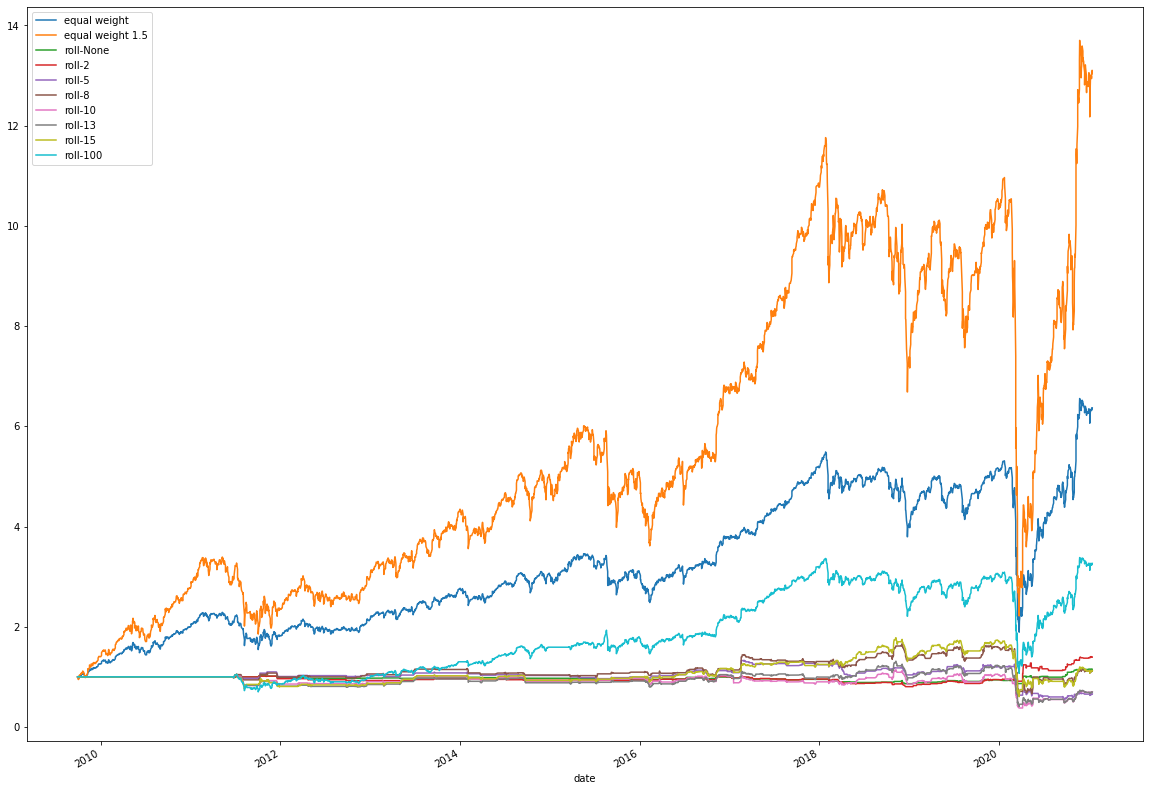

In [53]:
factor = data[4].unstack()
rets_imp, drets_imp, gwgts = performance_data_list(factor, returns, rolls=[2, 5, 8, 10, 13, 15, 100], groups=sp500_gics)
rets_imp.plot(figsize=(20, 15))
nperf.sharpe(drets_imp, returns_ref=drets_imp['equal weight']).sort_values()

roll-2             -0.199538
roll-None          -0.197954
roll-8             -0.069834
roll-5             -0.055207
roll-10            -0.003161
equal weight        0.000000
roll-100            0.023601
roll-15             0.053545
roll-13             0.080378
equal weight 1.5    0.245652
dtype: float64

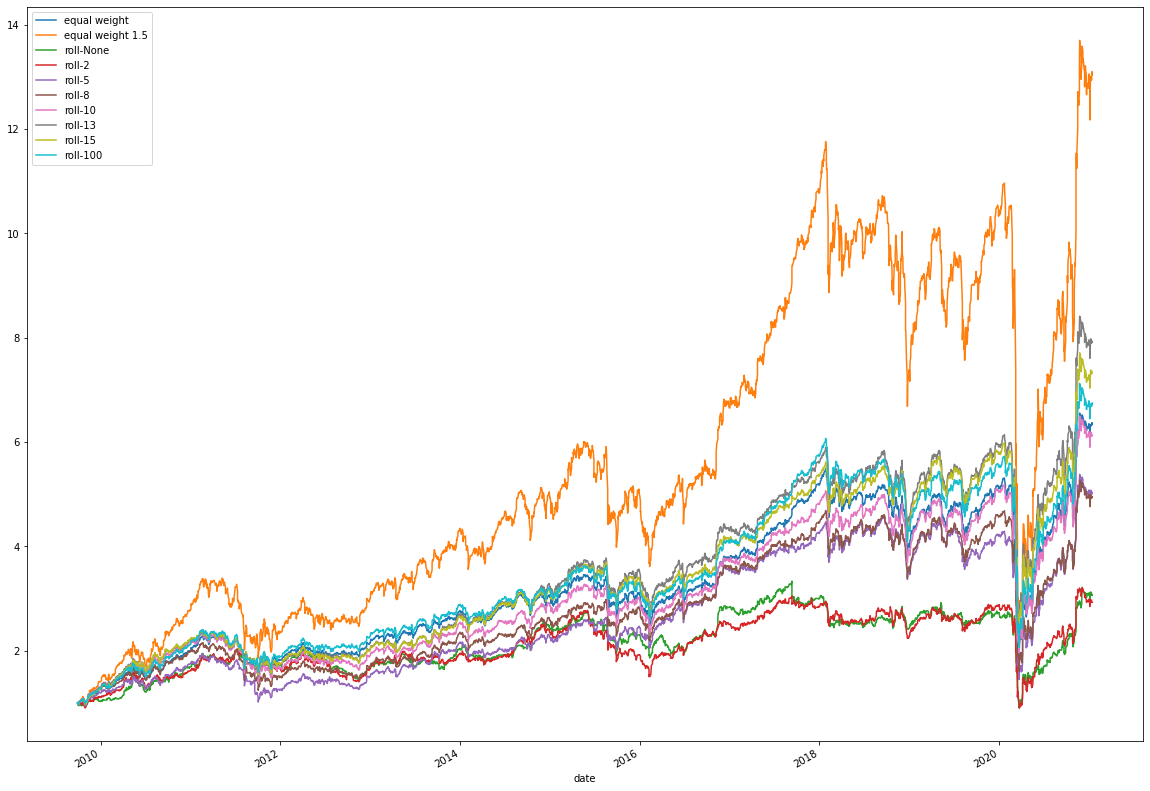

In [54]:
factor = data[5].unstack()
rets_imp, drets_imp, gwgts = performance_data_list(factor, returns, rolls=[2, 5, 8, 10, 13, 15, 100], groups=sp500_gics)
rets_imp.plot(figsize=(20, 15))
nperf.sharpe(drets_imp, returns_ref=drets_imp['equal weight']).sort_values()

roll-None          -0.138604
roll-2             -0.093462
equal weight        0.000000
roll-100            0.002824
roll-15             0.060622
roll-10             0.074327
roll-13             0.076489
roll-8              0.089661
roll-5              0.125123
equal weight 1.5    0.245652
dtype: float64

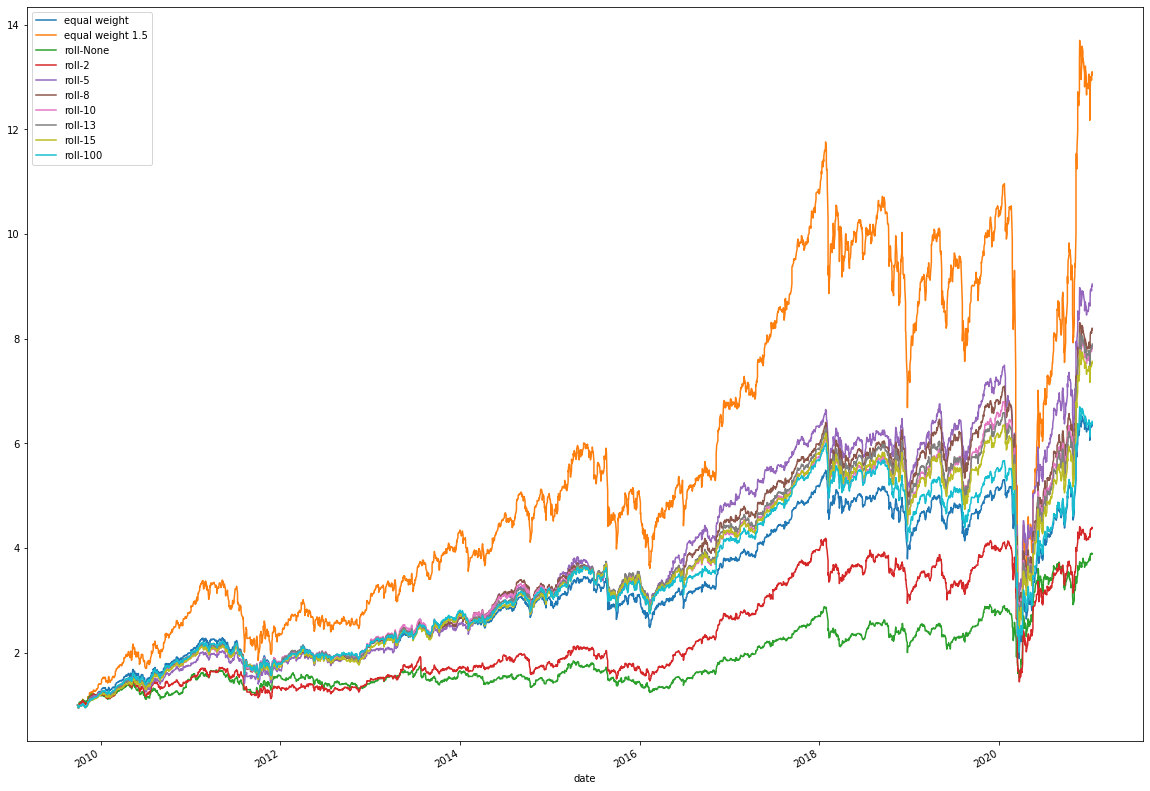

In [55]:
factor = data[6].unstack()
rets_imp, drets_imp, gwgts = performance_data_list(factor, returns, rolls=[2, 5, 8, 10, 13, 15, 100], groups=sp500_gics)
rets_imp.plot(figsize=(20, 15))
nperf.sharpe(drets_imp, returns_ref=drets_imp['equal weight']).sort_values()

roll-2             -0.276954
roll-5             -0.206431
roll-None          -0.181830
roll-8             -0.112861
roll-10            -0.093276
roll-15            -0.052847
roll-13            -0.048203
roll-100           -0.007621
equal weight        0.000000
equal weight 1.5    0.245652
dtype: float64

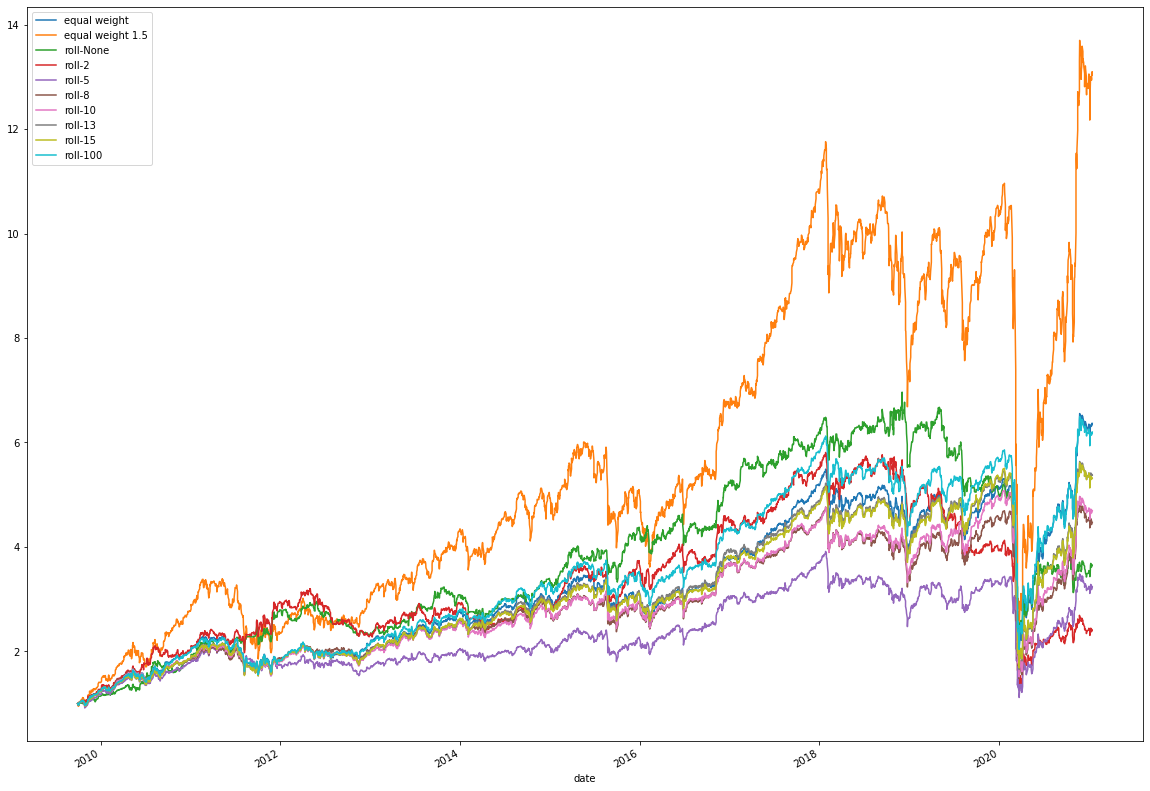

In [56]:
factor = data[7].unstack()
rets_imp, drets_imp, gwgts = performance_data_list(factor, returns, rolls=[2, 5, 8, 10, 13, 15, 100], groups=sp500_gics)
rets_imp.plot(figsize=(20, 15))
nperf.sharpe(drets_imp, returns_ref=drets_imp['equal weight']).sort_values()

roll-None          -0.793831
roll-2             -0.609508
roll-8             -0.139218
roll-5             -0.103521
roll-15            -0.096224
equal weight        0.000000
roll-100            0.023636
roll-10             0.039478
roll-13             0.047666
equal weight 1.5    0.245652
dtype: float64

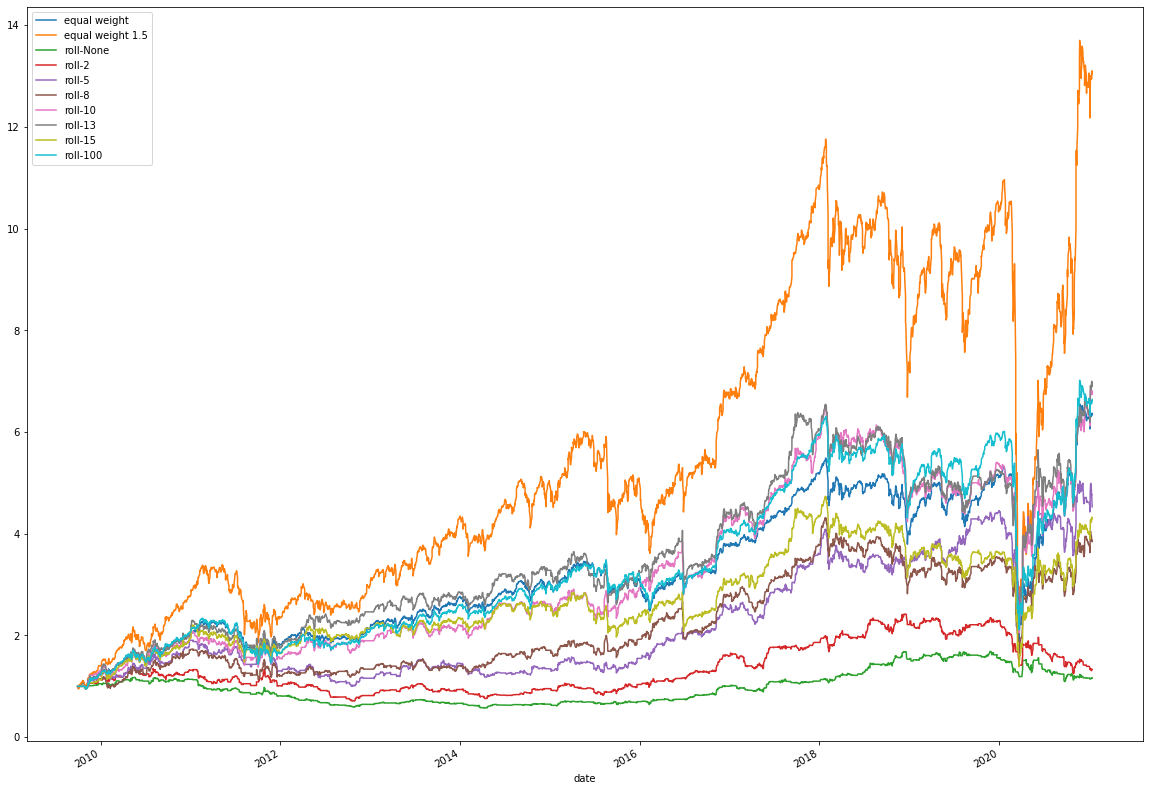

In [57]:
factor = data[8].unstack()
rets_imp, drets_imp, gwgts = performance_data_list(factor, returns, rolls=[2, 5, 8, 10, 13, 15, 100], groups=sp500_gics)
rets_imp.plot(figsize=(20, 15))
nperf.sharpe(drets_imp, returns_ref=drets_imp['equal weight']).sort_values()

roll-2             -0.563968
roll-None          -0.393078
roll-5             -0.127787
roll-8             -0.080449
roll-10            -0.076051
roll-15            -0.048774
roll-13            -0.040739
equal weight        0.000000
roll-100            0.002996
equal weight 1.5    0.245652
dtype: float64

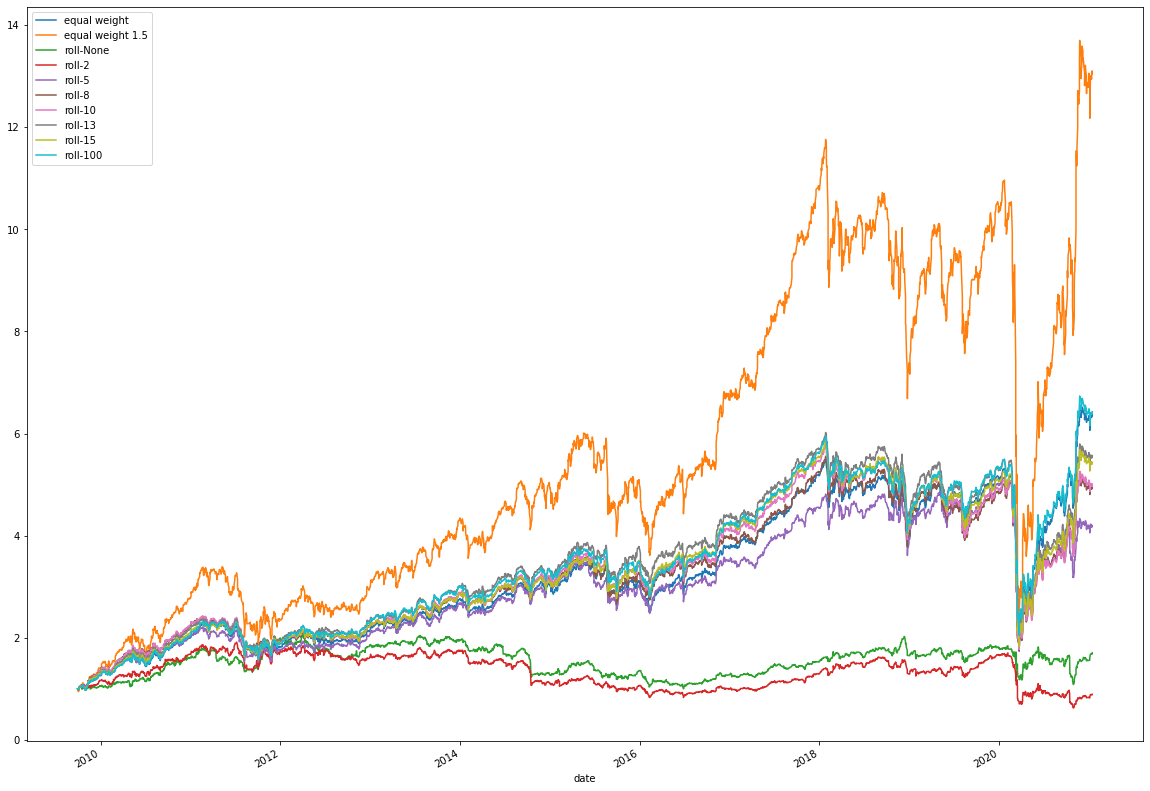

In [58]:
factor = data[9].unstack()
rets_imp, drets_imp, gwgts = performance_data_list(factor, returns, rolls=[2, 5, 8, 10, 13, 15, 100], groups=sp500_gics)
rets_imp.plot(figsize=(20, 15))
nperf.sharpe(drets_imp, returns_ref=drets_imp['equal weight']).sort_values()